# Семинар 5

# Ensembles
<h3> План семинара </h3>

* **Bagging** 
 - Bootstrap
 - Как построить доверительный интревал с помощью bootstrap
 - Описание композиции Bagging
 - Bagging в применении в DT
 
* **Boosting**
 - Описание Boosting
 - Gradient Boosting, XGBoost
 - XgBoost, CatBoost

* **Bias-vairance trade-off**
  - Разложение ошибки на Bias и Variance
  - bias\variance для bagging и boosting
    
* **Random Forest** 
 - Алгоритм построения случайного леса
 - Применение RandomForest на реальной задаче (предсказание оттока клиентов)
 - Out-of-bag error
 - Отбор признаков с помощью Random Forest
 
* **Основные выводы** 

In [47]:
from IPython.display import Image

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_digits as load
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

----------
<h1 align="center">Bagging</h1> 

** Вопросы для самоконтроля**
* Зачем нужно строит композиции над алгоритмами?
* Что такое bootstrap-выборка?
* Что такие RSM, Pasting?
* Какие бывают варианты построения композиций N базовых алгоритмов классификации?
* Что такое Bagging?
* Почему работает Bagging?

### Bootstrap

<img src='pics/bootstrap.png'>

### Как построить доверительный интервал с помощью бутстрепа?

Данные можно взять тут: https://github.com/Yorko/mlcourse_open/blob/master/data/telecom_churn.csv

In [18]:
telecom_data = pd.read_csv('telecom_churn.csv')

In [20]:
telecom_data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


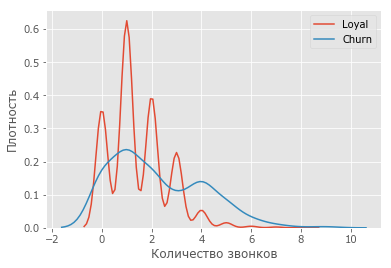

In [21]:
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label = 'Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label = 'Churn')        
fig.set(xlabel='Количество звонков', ylabel='Плотность')    
plt.show()

In [22]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [24]:
# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls= telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(churn_calls, 1000)]

In [25]:
#  выводим интервальную оценку среднего
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn:  mean interval",  stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal:  mean interval [1.4077193  1.49473684]
Service calls from churn:  mean interval [2.0621118  2.39761905]


### Bagging

## $$a_{Bagging}(x) = \frac{1}{M}\sum_{i=1}^M a_i(x)$$

$a_i(x)$ - обучен на бутстреп-выборке $X^i$

<img src='pics/bagging.png'>

In [27]:
iris = load()
X = iris.data
y = iris.target

f = X.shape[1]

rnd_d3 = DecisionTreeClassifier(max_features=int(f ** 0.5)) # Решающее дерево с рандомизацией в сплитах
d3 = DecisionTreeClassifier() # Обычное решающее дерево

Качество классификации одним решающим деревом:

In [31]:
print("Decision tree:", cross_val_score(d3, X, y).mean())

Decision tree: 0.7824306400405998


Качество бэггинга над решающими деревьями:

In [34]:
print("Bagging:", cross_val_score(BaggingClassifier(d3), X, y).mean())

Bagging: 0.8814474695668654


- Какой недостаток есть у деревьев?
- Как bagging борется с этим недостатком?

- Как можно улучшить качество? При построении каждого узла отбирать случайные max_features признаков и искать информативное разбиение только по одному из них.

In [38]:
print("Randomized Bagging:", cross_val_score(BaggingClassifier(rnd_d3), X, y).mean())

Randomized Bagging: 0.909825889142908


-----
<h1 align="center">Boosting</h1> 

** Вопросы для самоконтроля**
* Какое решающее правило применяется для базовых алгоритмов в Boosting?
* Как подбираются веса базовых алгоритмов?
* Можно ли распараллелить построение композиции boosting?
* В чем основные особенности GradientBoosting? Что такое Stochastic GradientBoosting?
* В чём основные особенности XGBoost?

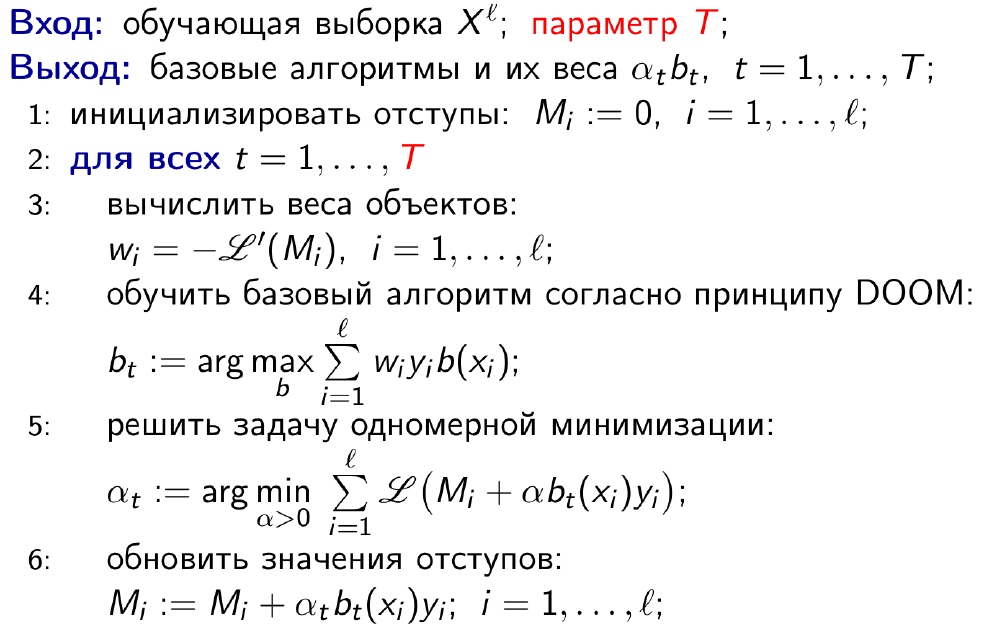

In [9]:
# Boosting
Image('pic/Boosting.png', height=600, width=600)

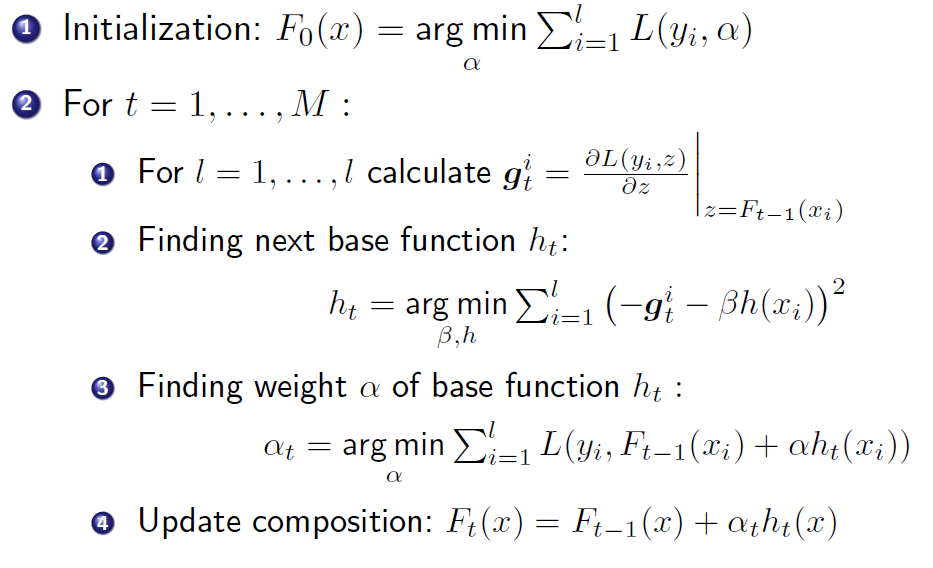

In [11]:
# Gradient Boosting
Image('pic/GBM.png', height=600, width=600)

### XGBoost

<img src='pics/xgboost.png' width=200>

1. Базовый алгоритм приближает направление, посчитанное с учетом вторых производных функции потерь.

2. Отклонение направления, построенного базовым алгоритмом, измеряется с помощью модифицированного функционала — из него удалено деление на вторую производную, за счет чего избегаются численные проблемы.

3. Функционал регуляризуется -- добавляются штрафы за количество листьев и за норму коэффициентов.

4. При построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига.

5. Критерий останова при обучении дерева также зависит от оптимального сдвига.

### CatBoost

<img src='pics/catboost.png' width=500>

https://github.com/catboost/catboost

https://tech.yandex.com/catboost/doc/dg/concepts/about-docpage/

In [ ]:
# TODO пример

<h1 align="center">Bias-Variance Tradeoff</h1> 

###  Разложение ошибки на Bias и Variance

#### Какя природа бывает у ошибок

<img src="pics/bv_darts.png", width=400>

#### Как это отражается на модели

<img src="pics/bv_model_complex.png">


### Bias\variance для Bagging и Boosting

### Смещение для беггинга

<img src="pics/bag_mu1.png">

<img src="pics/bag_mu2.png">

### Разброс для беггинга

<img src="pics/bag_var1.png">

<img src="pics/bag_var2.png">

<img src="pics/bag_var3.png">
Help: Раздел 3.2 https://github.com/esokolov/ml-course-msu/blob/master/ML15-spring/lecture-notes/Sem04_ensembles.pdf

<span style='color:red; font-size:12pt'> Bagging уменьшает дисперсию! </span> - используйте "strong learner" (НЕбольшое смещение, большой разброс)

<span style='color:red; font-size:12pt'> Boosting уменьшает разброс! </span> - используйте "weak learner" (большое смещение, НЕбольшой разброс) 

### Random Forest

<img src='pics/forest.jpeg' width=700>

##### Алгоритм построения случайного леса из $N$ деревьев

Для каждого $n = 1..N$:

Сгенерировать выборку $X_n$ с помощью бутстрэпа;
Построить решающее дерево $b_n$ по выборке $X_n$:
    - по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
    - дерево строится, пока в каждом листе не более $n_{min}$ объектов или пока не достигнем определенной высоты дерева
    - при каждом разбиении сначала выбирается $m$ случайных признаков из $n$ исходных, и оптимальное разделение выборки ищется только среди них.

Итоговый классификатор:
    $$ a(x) = \dfrac{1}{N} \sum_{i=1}^{N} b_i(x)$$

$m$ советуют выбирать равным:
- $\sqrt{n}$ для классификации
- $\dfrac{n}{3}$ для регрессии

### Random Forest из sklearn

Полный список параметров случайного леса для задачи регрессии:

In [ ]:
class sklearn.ensemble.RandomForestRegressor(
    n_estimators — число деревьев в "лесу" (по дефолту – 10)
    criterion — функция, которая измеряет качество разбиения ветки дерева (по дефолту — "mse" , так же можно выбрать "mae")
    max_features — число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto".
    max_depth — максимальная глубина дерева  (по дефолту глубина не ограничена)
    min_samples_split — минимальное количество объектов, необходимое для разделения внутреннего узла. Можно задать числом или процентом от общего числа объектов (по дефолту — 2)
    min_samples_leaf — минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1)
    min_weight_fraction_leaf — минимальная взвешенная доля от общей суммы весов (всех входных объектов) должна быть в листе (по дефолту имеют одинаковый вес)
    max_leaf_nodes — максимальное количество листьев (по дефолту нет ограничения)
    min_impurity_split — порог для остановки наращивания дерева (по дефолту 1е-7)
    bootstrap — применять ли бустрэп для построения дерева (по дефолту True)
    oob_score — использовать ли out-of-bag объекты для оценки R^2 (по дефолту False)
    n_jobs — количество ядер для построения модели и предсказаний (по дефолту 1, если поставить -1, то будут использоваться все ядра)
    random_state — начальное значение для генерации случайных чисел (по дефолту его нет, если хотите воспроизводимые результаты, то нужно указать любое число типа int
    verbose — вывод логов по построению деревьев (по дефолту 0)
    warm_start — использует уже натренированую модель и добавляет деревьев в ансамбль (по дефолту False)
)


Для задачи классификации все почти то же самое, мы приведем только те параметры, которыми RandomForestClassifier отличается от RandomForestRegressor:

In [ ]:
class sklearn.ensemble.RandomForestClassifier(
    criterion — поскольку у нас теперь задача классификации, то по дефолту выбран критерий "gini" (можно выбрать "entropy")
    class_weight — вес каждого класса (по дефолту все веса равны 1, но можно передать словарь с весами, либо явно указать "balanced", тогда веса классов будут равны их исходным частям в генеральной совокупности; также можно указать "balanced_subsample", тогда веса на каждой подвыборке будут меняться в зависимости от распределения классов на этой подвыборке.
)

При построениии модели в первую очередь стоит обратить внимание на следующие параметры:

- n_estimators — число деревьев в "лесу"
- criterion — критерий для разбиения выборки в вершине
- max_features — число признаков, по которым ищется разбиение
- min_samples_leaf — минимальное число объектов в листе
- max_depth — максимальная глубина дерева


### Применение RandomForest на реальной задаче (предсказание оттока клиентов)

Данные можно взять тут: https://github.com/Yorko/mlcourse_open/blob/master/data/telecom_churn.csv

In [5]:
# Загружаем данные
df = pd.read_csv("telecom_churn.csv")

# Выбираем сначала только колонки с числовым типом данных
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)

# Разделяем на признаки и объекты
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

# Инициализируем страифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# Обучаем на тренировочном датасете
results = cross_val_score(rfc, X, y, cv=skf)

# Оцениваем долю верных ответов на тестовом датасете
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 91.48%


Улучшим этот результат: посмотрим, как ведут себя кривые валидации при изменении основных параметров

In [6]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.44% with 50 trees


Text(0.5,0,'N_estimators')

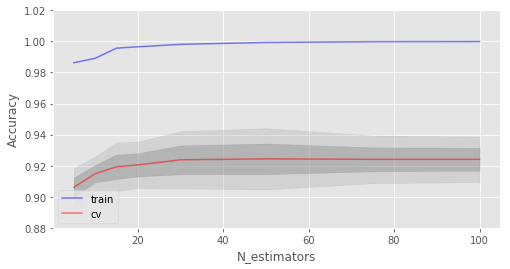

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

Подбираем параметр max_depth:

In [8]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.68% with 17 max_depth


Text(0.5,0,'Max_depth')

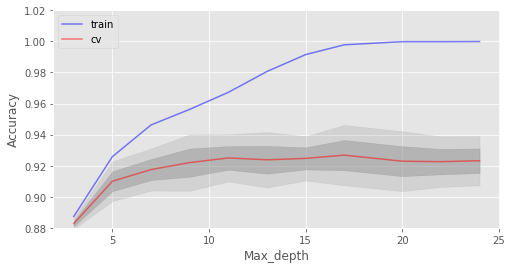

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

Параметр max_depth хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся. 

Параметр min_samples_leaf также выполняет функцию регуляризатора.

In [10]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.41% with 3 min_samples_leaf


Text(0.5,0,'Min_samples_leaf')

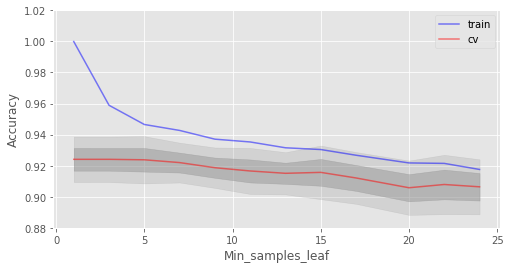

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

Рассмотрим такой параметр как max_features. Для задач классификации по умолчанию используется $\sqrt{n}$, где $n$ — число признаков.

In [12]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.59% with 12 max_features


Text(0.5,0,'Max_features')

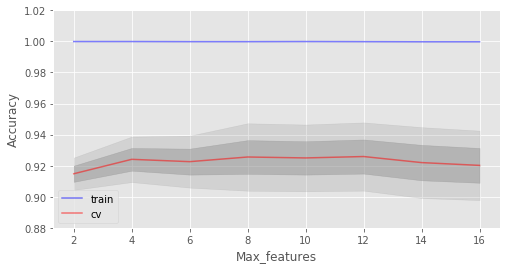

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

В нашем случае оптимальное число признаков - 10.

Итак, итоговый перебор параметров будет выглядеть следующим образом:

In [14]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

### Есть ли переобучение с увеличением числа деревьев?

In [40]:
from sklearn.metrics import accuracy_score

In [42]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.9876265466816648 test_acc = 0.8993993993993994
n_estimators =   40 train_acc = 0.9981252343457068 test_acc = 0.9114114114114115
n_estimators =  100 train_acc =  1.0 test_acc = 0.9099099099099099
n_estimators =  200 train_acc =  1.0 test_acc = 0.9054054054054054
n_estimators =  600 train_acc =  1.0 test_acc = 0.9024024024024024
n_estimators = 1000 train_acc =  1.0 test_acc = 0.9069069069069069
CPU times: user 2.84 s, sys: 1.09 s, total: 3.93 s
Wall time: 20.3 s


In [43]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.9823772028496438 test_acc = 0.9054054054054054
n_estimators =   40 train_acc = 0.9865016872890888 test_acc = 0.9069069069069069
n_estimators =  100 train_acc = 0.9857517810273716 test_acc = 0.9069069069069069
n_estimators =  200 train_acc = 0.9846269216347957 test_acc = 0.9054054054054054
n_estimators =  600 train_acc = 0.9872515935508062 test_acc = 0.9039039039039038
n_estimators = 1000 train_acc = 0.9868766404199475 test_acc = 0.9099099099099099
CPU times: user 2.7 s, sys: 991 ms, total: 3.69 s
Wall time: 19.8 s


In [44]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.9823772028496438 test_acc = 0.8933933933933934
n_estimators =   40 train_acc = 0.9820022497187851 test_acc = 0.9129129129129129
n_estimators =  100 train_acc = 0.9853768278965129 test_acc = 0.9039039039039038
n_estimators =  200 train_acc = 0.9857517810273716 test_acc = 0.9054054054054054
n_estimators =  600 train_acc = 0.9868766404199475 test_acc = 0.9069069069069069
n_estimators = 1000 train_acc = 0.9868766404199475 test_acc = 0.9069069069069069
CPU times: user 2.69 s, sys: 1.03 s, total: 3.72 s
Wall time: 19.6 s


### Out-of-bag error

<img src='pics/oob.png' width=700>

**Задача** Покажите, что примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.

**Решение** Пусть в выборке $l$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью $\dfrac{1}{l}$. Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $l$ раз): $(1-\dfrac{1}{l})^l$


$$\lim_{l \rightarrow +\infty} (1-\dfrac{1}{l})^l = \dfrac{1}{e}$$

Тогда вероятность попадания конкретного объекта в подвыборку $1 - \dfrac{1}{e} \approx 63\%$.

Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

### Отбор признаков с помощью случайного леса

<img src='pics/features.png'>

Данные можно взять здесь: https://github.com/Yorko/mlcourse_open/blob/master/data/hostel_factors.csv

Populating the interactive namespace from numpy and matplotlib
Feature ranking:
1. Персонал 0.182757 
2. Цена/качество 0.148373 
3. Состояние общего пространства 0.128296 
4. Дополнительные услуги 0.116604 
5. ССЦ 0.106668 
6. Общие условия и удобства 0.088589 
7. Состояние общей кухни 0.074273 
8. Заезд в хостел и выезд из хостела 0.061521 
9. Бронирование хостела  0.053615 
10. Состояние комнаты 0.039305 


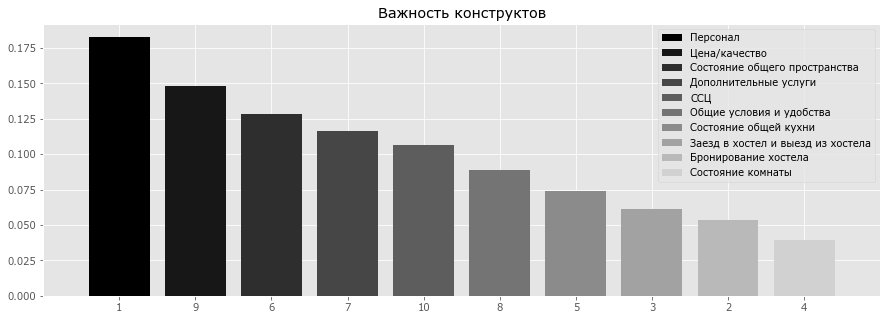

In [17]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

hostel_data = pd.read_csv("hostel_factors.csv")
features = {"f1":u"Персонал",
"f2":u"Бронирование хостела ",
"f3":u"Заезд в хостел и выезд из хостела",
"f4":u"Состояние комнаты",
"f5":u"Состояние общей кухни",
"f6":u"Состояние общего пространства",
"f7":u"Дополнительные услуги",
"f8":u"Общие условия и удобства",
"f9":u"Цена/качество",
"f10":u"ССЦ"}

forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices])

### Советы

1. По умолчанию в sklearn-овских методах n_jobs=1, т.е. случайный лес строится на одном процессоре. Если Вы хотите существенно ускорить построение, используйте n_jobs=-1 (строить на максимально возможном числе процессоров). Для построения воспроизводимых экспериментов используйте предустановку генератора псевдослучайных чисел: random_state.
2. Смешивать RF, обученные на разных подмножествах признаков

<img src='pics/diakonov_1.png'>

<h1 align="center">Выводы</h1> 

**Bagging**:
    - Одна из лучших техник для построения алгоритмов ML
    - Линейно уменьшает разброс и не уменьшает смещение (если не коррелированы ответы базовых алоритмов) 
    - Слабое переобучение
    - НО переобучение ЕСТЬ -- от сложности одного алгоритма, лучше все же немного обрезать деревья
** Boosting **
   - Один из лучших методов построения композиций
   - Нужно много деревьев и желательно не тысячи признаков
   - Много хороших реализаций (XgBoost, CatBoost)
    
** Random Forest **

Плюсы:
- имеет высокую точность предсказания, на большинстве задач будет лучше линейных алгоритмов; точность сравнима с точностью бустинга
- практически не чувствителен к выбросам в данных из-за случайного сэмлирования
- не чувствителен к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков, связано с выбором случайных подпространств
- не требует тщательной настройки параметров, хорошо работает «из коробки». С помощью «тюнинга» параметров можно достичь прироста от 0.5 до 3% точности в зависимости от задачи и данных
- способен эффективно обрабатывать данные с большим числом признаков и классов
- одинаково хорошо обрабатывет как непрерывные, так и дискретные признаки
- редко переобучается, на практике добавление деревьев почти всегда только улучшает композицию, но на валидации, после достижения определенного количества деревьев, кривая обучения выходит на асимптоту
- для случайного леса существуют методы оценивания значимости отдельных признаков в модели
- хорошо работает с пропущенными данными; сохраняет хорошую точность, если большая часть данных пропущенна
- предполагает возможность сбалансировать вес каждого класса на всей выборке, либо на подвыборке каждого дерева
- вычисляет близость между парами объектов, которые могут использоваться при кластеризации, обнаружении выбросов или (путем масштабирования) дают интересные представления данных
- возможности, описанные выше, могут быть расширены до неразмеченных данных, что приводит к возможности делать кластеризацию и визуализацию данных, обнаруживать выбросы
- высокая параллелизуемость и масштабируемость.

Минусы:
- в отличие от одного дерева, результаты случайного леса сложнее интерпретировать
- нет формальных выводов (p-values), доступных для оценки важности переменных
- алгоритм работает хуже многих линейных методов, когда в выборке очень много разреженных признаков (тексты, Bag of words)
- случайный лес не умеет экстраполировать, в отличие от той же линейной регрессии (но это можно считать и плюсом, так как не будет экстремальных значений в случае попадания выброса)
- алгоритм склонен к переобучению на некоторых задачах, особенно на зашумленных данных
- для данных, включающих категориальные переменные с различным количеством уровней, случайные леса предвзяты в пользу признаков с большим количеством уровней: когда у признака много уровней, дерево будет сильнее подстраиваться именно под эти признаки, так как на них можно получить более высокое значение оптимизируемого функционала (типа прироста информации)
- если данные содержат группы коррелированных признаков, имеющих схожую значимость для меток, то предпочтение отдается небольшим группам перед большими
- больший размер получающихся моделей. Требуется $O(NK)$ памяти для хранения модели, где $K$ — число деревьев.